# Image Generation Using Denoising Diffusion Models

This notebook has been partly adapted from the excellent diffusion model [tutorial](https://huggingface.co/blog/annotated-diffusion) by Rogge & Rasul and follows the original [DDPM paper](https://arxiv.org/abs/2006.11239) by Ho et al.

### **📌 The Core Idea of Diffusion Models**
While GANs can produce high-quality results, they are notorious for unstable training. Diffusion models offer a more stable alternative. They work by reversing a gradual noising process.

1.  **Forward (Diffusion) Process**: We start with a real image and slowly add Gaussian noise over a series of timesteps (`T`). This is a fixed, non-trainable process that eventually turns the image into pure noise.

2.  **Reverse (Denoising) Process**: We train a neural network (typically a U-Net) to reverse this process. Starting from random noise, the model learns to gradually remove the noise at each timestep, ultimately generating a clean, realistic image.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Lambda, Resize, CenterCrop, Normalize
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import numpy as np
from PIL import Image
import os
import kagglehub
import matplotlib.animation as animation
from matplotlib import rc

### **🔹 Model Configuration**
Here we define the key hyperparameters for our model and training process.

In [34]:
EPOCHS = 100
LEARNING_RATE = 1e-3
BATCH_SIZE = 128 
TIME_EMBEDDING_DIM = 200
TIMESTAMPS = 500
IMAGE_SIZE = 64  # Anime faces will be resized to 64x64

## 1️⃣ The Dataset: Anime Faces
- **Images**: Anime-style portrait images **(64x64, RGB)**
- **Shape**: `(batch_size, 3, 64, 64)`
- **Normalization**: Images are transformed from `[0, 255]` to `[0, 1]` (via `ToTensor`) and then to `[-1, 1]`. This normalization helps stabilize training.

In [35]:
transform_steps = Compose([
    Resize(IMAGE_SIZE),          # Resize to a consistent 64x64
    CenterCrop(IMAGE_SIZE),      # Crop to the center to ensure dimensions
    ToTensor(),                  # Convert image to a PyTorch tensor (scales to [0, 1])
    Lambda(lambda t: (t * 2) - 1)  # Normalize to the range [-1, 1]
])

In [36]:
# Download the dataset from Kaggle
path = kagglehub.dataset_download("soumikrakshit/anime-faces")
print("Path to dataset files:", path)

# The dataset path will be the downloaded path
dataset_path = os.path.join(path,'data')

Path to dataset files: /home/ali/.cache/kagglehub/datasets/soumikrakshit/anime-faces/versions/1


### **🔹 Custom Dataset Class**
We create a custom `Dataset` to load the image files from the directory and apply the defined transformations.

In [37]:
class AnimeFacesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, 0  # Return 0 as dummy label since we don't need labels

# Create dataset and dataloader
anime_dataset = AnimeFacesDataset(root_dir=dataset_path, transform=transform_steps)
train_dataloader = DataLoader(anime_dataset, batch_size=BATCH_SIZE, shuffle=True)

### **🔹 Displaying Sample Images**
Let's visualize a few images from our dataset to see what we're working with.

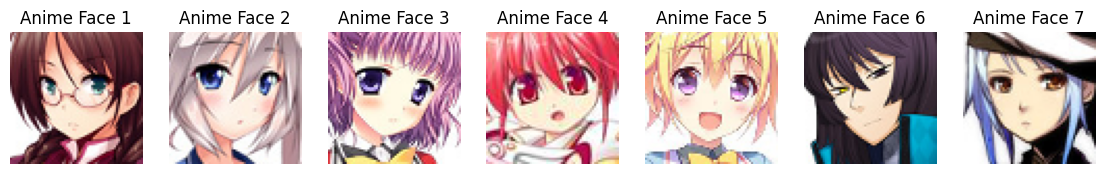

In [38]:
figure = plt.figure(figsize=(14, 14))
cols, rows = 7, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(anime_dataset), size=(1,)).item()
    img, _ = anime_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"Anime Face {i}")
    plt.axis("off")
    # Convert from [-1,1] back to [0,1] for display and clamp to valid range
    img_display = np.clip((img.numpy() + 1) / 2, 0, 1)
    plt.imshow(img_display.transpose(1, 2, 0))
plt.show()

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 2️⃣ The Theory: How Diffusion Models Work

### **🔹 The Forward Diffusion Process (q)**

The forward process, denoted as `q`, is a fixed Markov chain that gradually adds Gaussian noise to an image $\mathbf{x}_0$ over `T` timesteps. The amount of noise added at each step `t` is controlled by a **variance schedule** $\{\beta_t\}_{t=1}^T$.

$$
q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I})
$$

A key feature, which the authors call the **"nice property"**, allows us to sample a noisy image $\mathbf{x}_t$ directly from the original image $\mathbf{x}_0$ at any timestep `t`, without iterating through all the intermediate steps. This makes training very efficient.

Let $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$. Then:

$$
q(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
$$

This means we can get $\mathbf{x}_t$ by taking the original image $\mathbf{x}_0$, scaling it by $\sqrt{\bar{\alpha}_t}$, and adding scaled noise $\epsilon \sim \mathcal{N}(0, I)$:

$$
\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \, \mathbf{\epsilon}
$$




## 3️⃣ The Model: A U-Net for Noise Prediction

The model architecture needs to take a noisy image and a timestep as input and output a tensor of the same shape as the image (the predicted noise). A **U-Net** is perfectly suited for this task.

### **🔹 Key Architectural Components**
1.  **Downsampling Path**: A series of convolutional layers that reduce the spatial dimensions of the image, capturing contextual information.
2.  **Bottleneck**: A set of linear layers that process the flattened feature map.
3.  **Upsampling Path**: A series of transposed convolutional layers that increase the spatial dimensions back to the original image size.
4.  **Skip Connections**: Connections that link layers from the downsampling path to corresponding layers in the upsampling path. This is crucial for preserving high-frequency details and helps the model reconstruct the image accurately.
5.  **Time Embeddings**: Since the model needs to know *which* noise level `t` it's dealing with, we convert the scalar timestep `t` into a vector using **Sinusoidal Position Embeddings**. This vector is then incorporated into each block of the U-Net.

### **🔹 Helper Blocks for the U-Net**
First, we define the building blocks of our U-Net: convolutional blocks, upsampling blocks, and the time embedding module.

### **🔹 The Full Diffusion Model**
Now we assemble the blocks into the full U-Net architecture.

- **Input**: A batch of noisy images `x` of shape `(batch_size, 3, 64, 64)` and their corresponding timesteps `t` of shape `(batch_size,)`.
- **Output**: A tensor of predicted noise `ε_θ` with the same shape as the input image: `(batch_size, 3, 64, 64)`.


## 4️⃣ The Diffusion Process & Loss Function

### **🔹 Pre-calculating The Diffusion Schedule**

We need to define the variance schedule $\{\beta_t\}_{t=1}^T$. A simple linear schedule works well. From $\beta_t$, we can pre-calculate all the $\alpha_t$ and $\bar{\alpha}_t$ values needed for the forward process (`q_sample`) and the reverse sampling process.



### **🔹 The Forward Pass (`q_sample`)**

This function implements the "nice property" described earlier. It takes an original image `x_start` and a timestep `t` and returns a noisy version of the image at that timestep, $\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \, \mathbf{\epsilon}$



### **🔹 The Loss Function (`p_losses`)**
This function defines our training objective. For a given batch of images:
1.  A random noise tensor `noise` is created.
2.  A noisy version of the image, `x_noisy`, is created using `q_sample`.
3.  The model predicts the noise, `predicted_noise`, from `x_noisy`.
4.  The loss is the `smooth_l1_loss` (a robust version of MSE) between the `noise` and `predicted_noise`.

## 5️⃣ Training the Model
Now we're ready to train. The training loop performs the following steps for each batch:

1.  Load a batch of real images.
2.  For each image, sample a random timestep `t` from `0` to `T-1`.
3.  Calculate the loss using our `p_losses` function.
4.  Perform backpropagation to compute gradients.
5.  Update the model's weights using the optimizer.

### **🔹 Plotting the Training Progress**

## 6️⃣ Generating New Images (The Reverse Process)

Generating new images involves running the reverse process. We start with pure Gaussian noise (at timestep `T`) and iteratively apply our trained model to denoise it, one step at a time, until we reach timestep `0`.

The sampling process is summarized in the paper as Algorithm 2:

<img src="https://i.imgur.com/tTGrKg8.png" width="500" />

At each step `t`, the model predicts the noise $\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)$. We use this prediction to calculate the mean of the denoised image $\mathbf{x}_{t-1}$. Then, we add a small amount of variance (noise) back in, which is crucial for generating diverse samples.


### **🔹 Generating a Batch of Images**
Let's use our trained model to generate a grid of new anime faces.

### **🔹 Visualizing the Denoising Process**
We can create an animation to see how a single image evolves from pure noise to a recognizable face over the `T` sampling steps.

## 7️⃣ Conclusion & Next Steps

We have successfully built and trained a Denoising Diffusion Probabilistic Model (DDPM) to generate anime faces. We've seen how the model learns to reverse a fixed noising process to create new images from scratch.

### **📝 Exercises for Further Exploration**
1.  **Training Duration**: Train for more `EPOCHS`. Diffusion models benefit greatly from longer training. How do the results change after 200 or 500 epochs?
2.  **Timesteps**: Experiment with different `TIMESTAMPS` values (e.g., 200, 500, 1000). A larger `T` means a more gradual (and potentially more accurate) denoising process, but also slower sampling.
3.  **Beta Schedule**: The `linear_beta_schedule` is just one option. Research and implement other schedules, like a `cosine` schedule, which is often used in modern papers. How does it affect the final image quality?
4.  **Model Architecture**: Modify the U-Net. Try adding more ResNet-style blocks, using different attention mechanisms, or changing the number of channels (`64`, `128`, etc.) in the convolutional layers.
5.  **Dataset**: Try training this model on a different dataset, like CIFAR-10 or Fashion-MNIST. You will likely need to adjust the model architecture (e.g., `IMAGE_SIZE`, input channels) accordingly.

### Contributed by: Ali Habibullah.
